In [28]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

import numpy as np

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch
from torch import tensor
import torch.nn.functional as functional

### TODO
* Sostituire NLLLoss (negative log likelihood loss) con CrossEntropy. Rimuovere LogSoftmax
* Allenare word2vec su un file di 30MB preso dal nostro corpus
* classe encoder, classe decoder, classe uniti i due insieme

In [2]:
# unwanted characters
chars = [".", ",", "'", "-", ";", ":", '"', "(", ")", ".\n", "?\n", "!\n"]

def stripline(line, array = True ):
  """
  Strip the line from unwanted characters
  """

  line.replace('theyre', 'they are')
  line.replace('didnt', 'did not')
  line.replace('wasnt', 'was not')

  if array:
    return np.array([word for word in line.split(' ') if word not in chars])
  else:
    return [word for word in line.split(' ') if word not in chars]

### Word2Vec

In [3]:
# # train word2vec
# corpus = api.load('text8')
# old_model = Word2Vec(corpus)

In [4]:
f1 = open("test30.txt", "r")
lines = f1.readlines()
lines = [stripline(line, array = False) for line in lines]

In [5]:
model = Word2Vec(lines)

In [6]:
flat_list = [
    x
    for xs in lines
    for x in xs
]

In [7]:
vocab = set(flat_list)
len(vocab)

82297

### Pre-process Corpus

In [8]:
# load corpus
# f1 = open("test30.txt", "r") #text_text.txt
# lines = f1.readlines()

# end vector
end_vec = np.array([52 for _ in range(100)])

# min length of lines
min_len = 3

# vocabulary
vocab_index2key = model.wv.index_to_key
vocab_key2index = model.wv.key_to_index
id = np.identity(len(vocab_index2key)+1) # +1 because of the end_vec

print(len(vocab_index2key))

30241


In [9]:
def word2vec(word):
  return model.wv[word]

def vec2word(vec):
  return model.wv.most_similar(positive=[vec], topn=1)[0][0]

In [10]:
def line2vec(line):
  """
  Convert sentence to array of vectors
  """

  vectors = [word2vec(word) for word in line]
  vectors.append(end_vec)

  return np.array(vectors)

In [11]:
def onehot(word):
  """
  One hot encode the words, except for the end word (which doesn't exist anyway)
  """

  index = vocab_key2index[word]

  return id[index]

In [12]:
def sublines_vecs(vectors):
  """
  Return a sub-sentence and the following word
  """

  start_min = 3

  # choose the starting word
  starting_word = np.random.randint(start_min, len(vectors)-1) # randint doesn't return the last one

  # get the sub line
  f_vectors = vectors[starting_word:]

  # return one hot encoding of the following words. If one of the following words is the end token, then
  # don't use the onehat function, because the vocabulary doesn't have the end token
  one_hot_f_vectors = [id[-1] if (f_vector==end_vec).all() else onehot(vec2word(f_vector)) for f_vector in f_vectors]

  return vectors[:starting_word], one_hot_f_vectors

### Models

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(self.input_size, self.hidden_size)
        self.h2h = nn.Linear(self.hidden_size, self.hidden_size)

        self.relu = functional.relu
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, input, prev_hidden):
        current_hidden = self.relu(self.i2h(input) + self.h2h(prev_hidden))
        return current_hidden

    def initHidden(self):
        return torch.rand(self.hidden_size) #zeros?

In [14]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(self.input_size, self.hidden_size)
        self.h2h = nn.Linear(self.hidden_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, self.output_size)

        self.tanh = nn.Tanh()
        self.relu = functional.relu #leaky_relu
        self.softmax = nn.Softmax(dim=0)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, input, prev_hidden, hiddens_encoder):
        # hidden
        current_hidden = self.relu(self.i2h(input) + self.h2h(prev_hidden))

        # context
        scalar_products = tensor([torch.dot(prev_hidden, hidden_enc) for hidden_enc in hiddens_encoder])
        alphas = self.softmax(scalar_products)

        # weighted average of hiddens with alphas
        context = (torch.mul(torch.stack(hiddens_encoder, dim=1), alphas).t()/alphas.sum()).sum(dim=0)

        # pg 201 our choice of how to use the context vector
        context = self.tanh(context)
        current_hidden = context*current_hidden

        # produce output
        output = self.h2o(current_hidden)
        output = self.logsoftmax(output)

        return output, current_hidden

    def initHidden(self):
        return torch.rand(self.hidden_size) # not zeros due to the scalar product

    def initInput(self):
        return torch.rand(self.input_size) # zeros?

In [15]:
class GPT1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        super(GPT1, self).__init__()

        self.output_size = output_size

        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(input_size, hidden_size, output_size)

        self.loss = nn.NLLLoss()
        # https://discuss.pytorch.org/t/pytorch-combine-two-models-into-a-single-class-and-access-their-parameters-from-the-parent-class/83000
        self.optimizer = optim.Adam(
            self.parameters(),
            lr=lr)

    def forward(self, input_subline, one_hot_f_vectors=None, predict=False):

        # unroll encoder
        init_hidden_e = self.encoder.initHidden()
        hiddens_encoder = [self.encoder(tensor(vec).float(), init_hidden_e) for vec in input_subline]

        # unroll decoder
        init_hidden_d = self.decoder.initHidden()
        init_input_d = self.decoder.initInput()

        # predict outputs
        decoder_outputs = []

        # do
        decoder_outputs.append( self.decoder(init_input_d, init_hidden_d, hiddens_encoder) )

        # predict
        if predict:

          while np.argmax(output) != self.output_size:

            output, prev_hidden = decoder_outputs[-1]

            input = word2vec(vocab_index2key[np.argmax(output)])
            decoder_outputs.append( self.decoder(input, prev_hidden, hiddens_encoder) )

            if len(decoder_outputs) > 15:
              break

        # train
        else:

          for i in range(len(one_hot_f_vectors)-1):

            output, prev_hidden = decoder_outputs[-1]

            input = word2vec(vocab_index2key[torch.argmax(output).item()])
            decoder_outputs.append( self.decoder(tensor(input).float(), prev_hidden, hiddens_encoder) )

        # return distributions on the vocabulary
        return [decoder_output[0] for decoder_output in decoder_outputs]


### Test sandbox

In [16]:
line = lines[11]
# line = stripline(line)

print('Original sentence: ', line)

vectors = line2vec(line)

for _ in range(2):
  sub_vectors, one_hot_f_vectors = sublines_vecs(vectors)

  print('Sub sentence: ',[vec2word(vec) for vec in sub_vectors])

  for one_hot_f_vector in one_hot_f_vectors:
    if np.argmax(one_hot_f_vector) >= len(vocab_index2key):
      print('Next word: ', vec2word(end_vec))
    else:
      print('Next word: ', vocab_index2key[np.argmax(one_hot_f_vector)])
  print('\n')

Original sentence:  ['i', 'walked', 'along', 'the', 'empty', 'road', 'alone', 'occasionally', 'waving', 'to', 'passing', 'kids', 'on', 'bikes']
Sub sentence:  ['i', 'walked', 'along', 'the', 'empty', 'road', 'alone', 'occasionally']
Next word:  waving
Next word:  to
Next word:  passing
Next word:  kids
Next word:  on
Next word:  bikes
Next word:  wampus


Sub sentence:  ['i', 'walked', 'along', 'the', 'empty', 'road', 'alone']
Next word:  occasionally
Next word:  waving
Next word:  to
Next word:  passing
Next word:  kids
Next word:  on
Next word:  bikes
Next word:  wampus




In [45]:
gpt = GPT1(100, 300, len(id))

logprobs = gpt(sub_vectors, one_hot_f_vectors)
words = [vocab_index2key[torch.argmax(logprob).item()] for logprob in logprobs]

print(words)

['none', 'traversed', 'dumpster', 'aiden']


In [46]:
params_e = []
params_d = []
losses = []

for epoch in range(1, 200):

    pred_words = []
    true_words = []

    dim_batch = 8
    # batch of random lines
    batch = [lines[i] for i in np.random.randint(0, len(lines), dim_batch)]
    # batch = [stripline(lines[11]), stripline(lines[11])]

    for line in batch:

        # convert to vector
        try:
          vectors = line2vec(line)
          # divide into sub_line and labels
          sub_vectors, one_hot_f_vectors = sublines_vecs(vectors)
        except:print("key not present in vocab.")

        # gpt predicts
        logprobs = gpt(sub_vectors, one_hot_f_vectors)

        # out assumption that the prob(word1 & ... & wordn) = prob(word1)*...*prob(wordn)
        # --> log(prob(word1 & ... & wordn)) = sum log
        # --> sum on batch and sum on words is the same
        for logprob,one_hot_f_vector in zip(logprobs, one_hot_f_vectors):
          pred_words.append(logprob)
          true_words.append(tensor(one_hot_f_vector))

    # backpropagation
    gpt.zero_grad()

    pred_words = torch.stack(pred_words)
    true_words = torch.stack(true_words)

    loss = gpt.loss(pred_words[0], true_words[0].long())
    loss.backward()
    losses.append(loss)
    gpt.optimizer.step()

    params_e.append([p for p in gpt.encoder.parameters()])
    params_d.append([p for p in gpt.decoder.parameters()])

    # print(params_d[-1][0][0][0])
    # print(params_e[-1][0][0][0])

key not present in vocab.
tensor(0.1116, grad_fn=<SelectBackward0>)
tensor(-0.1222, grad_fn=<SelectBackward0>)
key not present in vocab.
key not present in vocab.
key not present in vocab.
tensor(0.1787, grad_fn=<SelectBackward0>)
tensor(-0.1892, grad_fn=<SelectBackward0>)
tensor(0.2305, grad_fn=<SelectBackward0>)
tensor(-0.2410, grad_fn=<SelectBackward0>)
key not present in vocab.
key not present in vocab.
key not present in vocab.
key not present in vocab.
tensor(0.2729, grad_fn=<SelectBackward0>)
tensor(-0.2834, grad_fn=<SelectBackward0>)
key not present in vocab.
key not present in vocab.
tensor(0.3087, grad_fn=<SelectBackward0>)
tensor(-0.3193, grad_fn=<SelectBackward0>)
key not present in vocab.
tensor(0.3396, grad_fn=<SelectBackward0>)
tensor(-0.3502, grad_fn=<SelectBackward0>)
key not present in vocab.
tensor(0.3666, grad_fn=<SelectBackward0>)
tensor(-0.3772, grad_fn=<SelectBackward0>)
key not present in vocab.
key not present in vocab.
key not present in vocab.
tensor(0.3904, 

In [48]:
logprobs = gpt(sub_vectors, one_hot_f_vectors)
words = [vocab_index2key[torch.argmax(logprob).item()] for logprob in logprobs]

print(words)

['the', 'the']


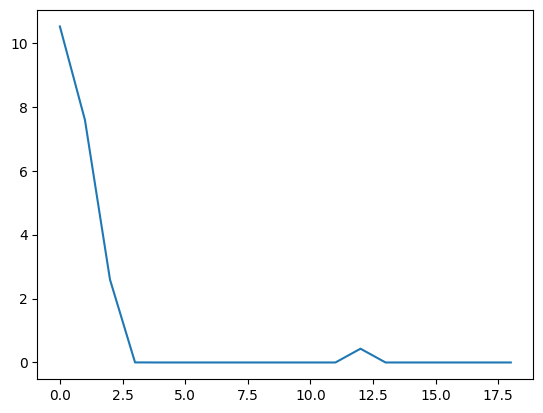

In [34]:
plt.plot([los.detach().numpy() for los in losses])

In [20]:
out = torch.stack(out)
out = torch.reshape(out, (batch, len(category_tensor)))
true_categories = torch.stack(true_categories)
loss = backpropagation(out, true_categories)


for epoch in range(1, n_epochs + 1):
    out = []
    true_categories = []
    for j in range(batch):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = predict(line_tensor)

        out.append(output)
        true_categories.append(category_tensor[0])

    out = torch.stack(out)
    out = torch.reshape(out, (batch, len(category_tensor)))
    true_categories = torch.stack(true_categories)
    loss = backpropagation(out, true_categories)

    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        mean_loss = current_loss / plot_every
        all_losses.append(mean_loss.detach

SyntaxError: incomplete input (<ipython-input-20-d7937bb5f84c>, line 33)

In [ ]:
# BATCH